<a href="https://colab.research.google.com/github/UmaNagirireddi/ML_7/blob/main/Rtml_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report, f1_score
import seaborn as sns

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Create and download CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
mean, std = torch.stack([img_t.mean((1,2)) for img_t, _ in train_dataset]).mean(0), torch.stack([img_t.std((1,2)) for img_t, _ in train_dataset]).mean(0)


100%|██████████| 170498071/170498071 [00:13<00:00, 12878577.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
mean, std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2023, 0.1994, 0.2010]))

In [ ]:
cifar_10Val = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [ ]:
cifar_10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [ ]:
firstImage, label = cifar_10[0]
print(firstImage.shape)

torch.Size([3, 32, 32])


In [ ]:
trainLoader = DataLoader(cifar_10, batch_size=32, shuffle=True, num_workers=2)
testLoader = DataLoader(cifar_10Val, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
classNames = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [ ]:
class ModelNet(nn.Module):
    def __init__(self):
        super(ModelNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*3, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)  # 10 classes

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
model = ModelNet().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
Train_loss_list, val_loss_list, val_accuracy_list = [], [], []

epochs = 20
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(trainLoader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    Train_loss_list.append(running_loss / len(trainLoader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    model.eval()
    all_predictions, all_targets = [], []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testLoader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.tolist())
            all_targets.extend(labels.tolist())

    val_loss_list.append(running_loss / len(testLoader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {Train_loss_list[-1]:.4f}, Validation loss: {val_loss_list[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch 1, Training loss: 1.8017, Validation loss: 1.6054, Validation Accuracy: 43.41%
Epoch 2, Training loss: 1.5511, Validation loss: 1.5064, Validation Accuracy: 47.40%
Epoch 3, Training loss: 1.4500, Validation loss: 1.4627, Validation Accuracy: 48.47%
Epoch 4, Training loss: 1.3788, Validation loss: 1.4052, Validation Accuracy: 50.41%
Epoch 5, Training loss: 1.3219, Validation loss: 1.4062, Validation Accuracy: 50.51%
Epoch 6, Training loss: 1.2739, Validation loss: 1.3759, Validation Accuracy: 51.44%
Epoch 7, Training loss: 1.2313, Validation loss: 1.3973, Validation Accuracy: 50.55%
Epoch 8, Training loss: 1.1937, Validation loss: 1.3963, Validation Accuracy: 51.63%
Epoch 9, Training loss: 1.1570, Validation loss: 1.3756, Validation Accuracy: 52.01%
Epoch 10, Training loss: 1.1239, Validation loss: 1.4071, Validation Accuracy: 51.51%
Epoch 11, Training loss: 1.0920, Validation loss: 1.3921, Validation Accuracy: 51.73%
Epoch 12, Training loss: 1.0631, Validation loss: 1.4231, Valid

In [ ]:
# Final evaluation
model.eval()
all_predictions, all_targets = [], []
with torch.no_grad():
    for i, (inputs, targets) in enumerate(testLoader, 0):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.tolist())
        all_targets.extend(targets.tolist())


In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(all_targets, all_predictions) * 100
precision, recall, f1 = precision_score(all_targets, all_predictions, average='weighted'), recall_score(all_targets, all_predictions, average='weighted'), f1_score(all_targets, all_predictions, average='weighted')

# Print the metrics
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 50.82%
Precision: 0.5140577427768094
Recall: 0.5082
F1 Score: 0.5077732114590972


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 402250


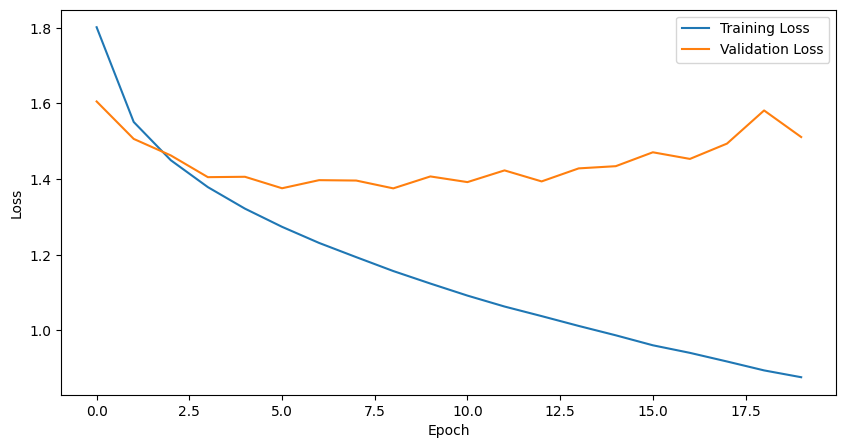

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(Train_loss_list , label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**1_B**

In [ ]:
class ModelNet(nn.Module):
    def __init__(self):
        super(ModelNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 128)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(128, 10)  # 10 classes

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
model = ModelNet().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
trainLossList, valLossList, valAccuracyList = [], [], []

for epoch in range(20):
    # Training loop
    model.train()
    trainLossList.append(sum(criterion(model(inputs.to(device)), labels.to(device)).item() for inputs, labels in trainLoader) / len(trainLoader))

    # Validation loop
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in testLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valLossList.append(val_loss / len(testLoader))
    valAccuracyList.append(100 * correct / total)

    print(f'Epoch {epoch + 1}, Training loss: {trainLossList[-1]}, Validation loss: {valLossList[-1]}, Validation Accuracy: {valAccuracyList[-1]}%')

trainLossList


Epoch 1, Training loss: 2.306495665741211, Validation loss: 2.3063211372485175, Validation Accuracy: 9.77%
Epoch 2, Training loss: 2.3064987642675048, Validation loss: 2.3063211372485175, Validation Accuracy: 9.77%
Epoch 3, Training loss: 2.3064915661009473, Validation loss: 2.3063211372485175, Validation Accuracy: 9.77%
Epoch 4, Training loss: 2.306512599866968, Validation loss: 2.3063211372485175, Validation Accuracy: 9.77%
Epoch 5, Training loss: 2.306497721510367, Validation loss: 2.3063211372485175, Validation Accuracy: 9.77%
Epoch 6, Training loss: 2.306493962184786, Validation loss: 2.3063211372485175, Validation Accuracy: 9.77%
Epoch 7, Training loss: 2.3065125107841467, Validation loss: 2.3063211372485175, Validation Accuracy: 9.77%
Epoch 8, Training loss: 2.30649931935721, Validation loss: 2.3063211372485175, Validation Accuracy: 9.77%
Epoch 9, Training loss: 2.306483157841883, Validation loss: 2.3063211372485175, Validation Accuracy: 9.77%
Epoch 10, Training loss: 2.30649248

[2.306495665741211,
 2.3064987642675048,
 2.3064915661009473,
 2.306512599866968,
 2.306497721510367,
 2.306493962184786,
 2.3065125107841467,
 2.30649931935721,
 2.306483157841883,
 2.306492480115103,
 2.3064789546275857,
 2.306500017223492,
 2.3064975317517535,
 2.306509223414474,
 2.3064852087297885,
 2.30650052228038,
 2.306498579847759,
 2.306507860020194,
 2.306487968619329,
 2.3064927833627906]

In [ ]:
allPredictions, allTargets = zip(*[(torch.max(model(inputs.to(device)).data, 1)[1].tolist(), targets.tolist()) for inputs, targets in testLoader])

# Flatten the nested lists
allPredictions = [item for sublist in allPredictions for item in sublist]
allTargets = [item for sublist in allTargets for item in sublist]



<Figure size 1000x800 with 0 Axes>

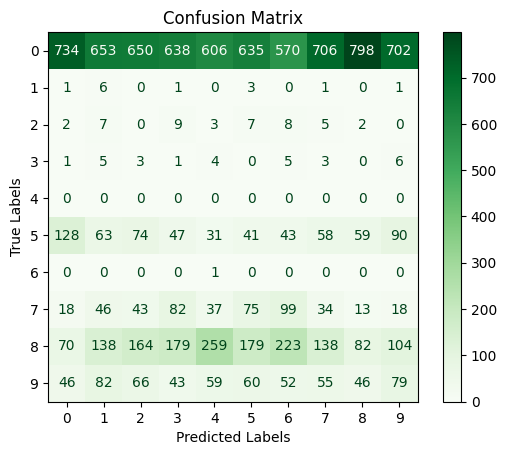

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(allPredictions, allTargets)
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(10))
plt.figure(figsize=(10, 8))
disp.plot(cmap="Greens", values_format="d")

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(allTargets, allPredictions) * 100
precision, recall, f1 = precision_score(allTargets, allPredictions, average='weighted'), recall_score(allTargets, allPredictions, average='weighted'), f1_score(allTargets, allPredictions, average='weighted')

# Print the metrics
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 9.77%
Precision: 0.09324621585274565
Recall: 0.0977
F1 Score: 0.046540413333384704


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 1640330


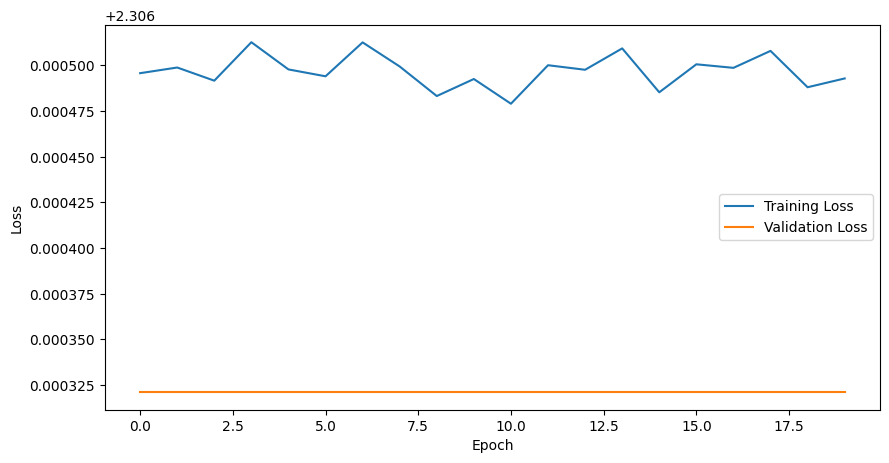

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(trainLossList, label='Training Loss')
plt.plot(valLossList, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**2_A**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score

In [ ]:
# Load dataset
df_train = pd.read_csv('/content/sample_data/house-train.csv')
df_test = pd.read_csv('/content/sample_data/house-test.csv')

# Define useful columns
useful_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath',
               'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'LotFrontage', 'WoodDeckSF',
               'OpenPorchSF']
target_col = 'SalePrice'

# Preprocess the dataset
df_train_prepro = df_train[useful_cols + [target_col]].copy()


In [ ]:
df_train_prepro.fillna(df_train_prepro.mean(), inplace=True)

X, y = df_train_prepro[useful_cols], df_train_prepro[target_col]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled, X_val_scaled = scaler.fit_transform(X_train), scaler.transform(X_val)


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors and create data loaders
train_loader = DataLoader(TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)), batch_size=32, shuffle=False)


In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()

        # Define layers
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        # Forward pass
        x = self.relu(self.fc2(self.relu(self.fc1(x))))
        return self.fc4(self.fc3(x))


In [ ]:
import torch.optim as optim

model = MLP(len(useful_cols))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        rmse_loss = torch.sqrt(criterion(output, y_batch))
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    y_pred, y_true, total_val_loss = [], [], 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            y_pred.extend(output.view(-1).tolist())
            y_true.extend(y_batch.view(-1).tolist())
            rmse_loss = torch.sqrt(criterion(output, y_batch))
            total_val_loss += rmse_loss.item()
    val_losses.append(total_val_loss / len(val_loader))

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


Epoch 1/100, Train Loss: 196459.4016, Val Loss: 196703.7547
Epoch 2/100, Train Loss: 196259.1482, Val Loss: 196579.6266
Epoch 3/100, Train Loss: 195941.3818, Val Loss: 195889.8594
Epoch 4/100, Train Loss: 194747.2247, Val Loss: 193449.1844
Epoch 5/100, Train Loss: 190153.4088, Val Loss: 187075.8797
Epoch 6/100, Train Loss: 180533.1448, Val Loss: 173820.8266
Epoch 7/100, Train Loss: 162872.8568, Val Loss: 150392.1109
Epoch 8/100, Train Loss: 134165.8714, Val Loss: 115453.8000
Epoch 9/100, Train Loss: 99835.3199, Val Loss: 79604.2926
Epoch 10/100, Train Loss: 77618.6913, Val Loss: 67000.0945
Epoch 11/100, Train Loss: 72266.7533, Val Loss: 63760.8078
Epoch 12/100, Train Loss: 69080.8878, Val Loss: 61131.9660
Epoch 13/100, Train Loss: 66457.7232, Val Loss: 58823.0994
Epoch 14/100, Train Loss: 63754.2343, Val Loss: 56453.5828
Epoch 15/100, Train Loss: 61516.1353, Val Loss: 54363.7771
Epoch 16/100, Train Loss: 59305.8869, Val Loss: 52385.2205
Epoch 17/100, Train Loss: 56796.7573, Val Loss: 5

MSE: 1117462569.4892716
RMSE: 33428.46944580729
R² Score: 0.8543135533867902


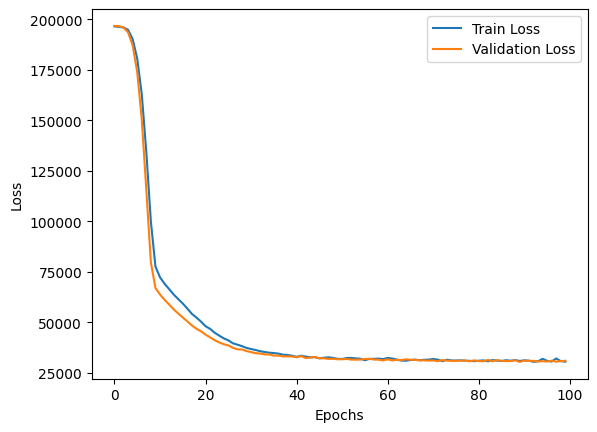

Total parameters: 11905


(None, None)

In [ ]:
import matplotlib.pyplot as plt

mse, rmse, r2 = mean_squared_error(y_true, y_pred), mean_squared_error(y_true, y_pred)**0.5, r2_score(y_true, y_pred)
print(f'MSE: {mse}\nRMSE: {rmse}\nR² Score: {r2}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.legend(), plt.show()

total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}'), torch.save(model, 'model_complete.pth')


**2_B**

In [ ]:
import numpy as np

# Select columns for training and preprocessing
df_train_prepro = df_train[useful_cols + [target_col]].copy()

# Identify numeric and categorical columns
numeric_cols, categorical_cols = df_train_prepro.select_dtypes(include=[np.number]).columns.tolist(), df_train_prepro.select_dtypes(exclude=[np.number]).columns.tolist()

# Fill missing values in numeric columns with mean
df_train_prepro[numeric_cols] = df_train_prepro[numeric_cols].fillna(df_train_prepro[numeric_cols].mean())

# Fill missing values in categorical columns with mode or a placeholder value
for col in categorical_cols: df_train_prepro[col] = df_train_prepro[col].fillna(df_train_prepro[col].mode()[0])

# One-hot encoding for categorical features
df_train_prepro = pd.get_dummies(df_train_prepro, columns=categorical_cols)

# Split dataset into features and target
X, y = df_train_prepro.drop(target_col, axis=1), df_train_prepro[target_col]


In [ ]:
# Split data and scale features
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled, X_val_scaled = scaler.fit_transform(X_train), scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor, y_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor, y_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# Create data loaders
train_dataset, val_dataset = TensorDataset(X_train_tensor, y_train_tensor), TensorDataset(X_val_tensor, y_val_tensor)
train_loader, val_loader = DataLoader(train_dataset, batch_size=64, shuffle=True), DataLoader(val_dataset, batch_size=64, shuffle=False)


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc4(self.relu(self.fc3(self.relu(self.fc2(self.relu(self.fc1(x)))))))
        return x

model = MLP(X_train_tensor.shape[1])
criterion, optimizer = nn.MSELoss(), optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs, train_losses, val_losses = 100, [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = sum(torch.sqrt(criterion(model(X), y)).item() for X, y in train_loader)
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    avg_val_loss = sum(torch.sqrt(criterion(model(X), y)).item() for X, y in val_loader) / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


Epoch 1/100, Train Loss: 195068.2064, Val Loss: 199343.0469
Epoch 2/100, Train Loss: 198305.8775, Val Loss: 199343.0469
Epoch 3/100, Train Loss: 196269.3125, Val Loss: 199343.0469
Epoch 4/100, Train Loss: 196915.5576, Val Loss: 199343.0469
Epoch 5/100, Train Loss: 195965.1571, Val Loss: 199343.0469
Epoch 6/100, Train Loss: 198603.2319, Val Loss: 199343.0469
Epoch 7/100, Train Loss: 196987.4391, Val Loss: 199343.0469
Epoch 8/100, Train Loss: 197428.7763, Val Loss: 199343.0469
Epoch 9/100, Train Loss: 197080.6604, Val Loss: 199343.0469
Epoch 10/100, Train Loss: 196333.4531, Val Loss: 199343.0469
Epoch 11/100, Train Loss: 197430.5888, Val Loss: 199343.0469
Epoch 12/100, Train Loss: 195361.6604, Val Loss: 199343.0469
Epoch 13/100, Train Loss: 196551.3051, Val Loss: 199343.0469
Epoch 14/100, Train Loss: 196523.8725, Val Loss: 199343.0469
Epoch 15/100, Train Loss: 197799.3586, Val Loss: 199343.0469
Epoch 16/100, Train Loss: 195457.6192, Val Loss: 199343.0469
Epoch 17/100, Train Loss: 196021.

In [ ]:
# Evaluation
model.eval()
y_pred, y_true = [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        y_pred.extend(model(X_batch).view(-1).tolist())
        y_true.extend(y_batch.view(-1).tolist())

mse, rmse, r2 = mean_squared_error(y_true, y_pred), (mean_squared_error(y_true, y_pred)) ** 0.5, r2_score(y_true, y_pred)

print(f'MSE: {mse}\nRMSE: {rmse}\nR² Score: {r2}')
print(f'Total parameters: {sum(p.numel() for p in model.parameters())}')
torch.save(model, 'model_complete.pth')


MSE: 39654063929.894585
RMSE: 199133.28182374383
R² Score: -4.169801499803043
Total parameters: 11905


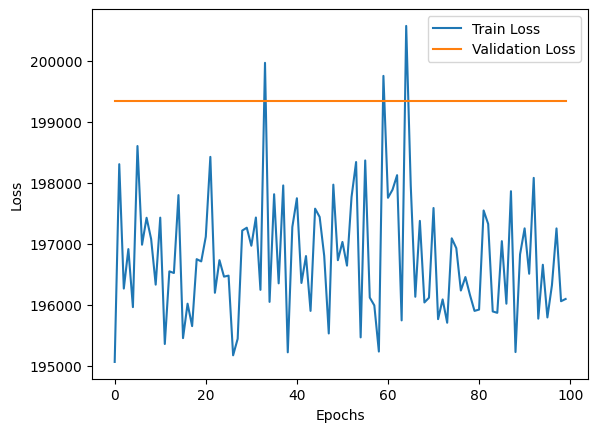

In [ ]:
# Plot training and validation loss
plt.plot(train_losses, label='Train Loss') # Training loss curve
plt.plot(val_losses, label='Validation Loss') # Validation loss curve
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


**2_C**

In [ ]:
useful_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath',
               'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'LotFrontage', 'WoodDeckSF',
               'OpenPorchSF', 'ExterQual', 'Neighborhood', 'MSZoning', 'Alley', 'LotShape',
               'LandContour', 'Condition1', 'HouseStyle', 'MasVnrType', 'SaleCondition']
target_col = 'SalePrice'

# Select and copy relevant columns
df_train_prepro = df_train[useful_cols + [target_col]].copy()

# Fill missing values for numeric columns with mean
df_train_prepro[numeric_cols] = df_train_prepro[numeric_cols].fillna(df_train_prepro[numeric_cols].mean())

# Fill missing values for categorical columns with mode
for col in categorical_cols:
    df_train_prepro[col] = df_train_prepro[col].fillna(df_train_prepro[col].mode()[0])

# Define categorical features for one-hot encoding
categorical_features = ['ExterQual', 'Neighborhood', 'MSZoning', 'Alley', 'LotShape',
                        'LandContour', 'Condition1', 'HouseStyle', 'MasVnrType', 'SaleCondition']

# One-hot encoding for categorical features
df_train_prepro = pd.get_dummies(df_train_prepro, columns=categorical_features)

# Split dataset into features and target
X = df_train_prepro.drop(target_col, axis=1)
y = df_train_prepro[target_col]


In [ ]:
# Split data and scale features
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled, X_val_scaled = scaler.fit_transform(X_train), scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor, y_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor, y_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# Create data loaders
train_loader, val_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True), DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)


In [ ]:
class MLP_extended(nn.Module):
    def __init__(self, input_size):
        super(MLP_extended, self).__init__()
        self.fc1, self.fc2, self.fc3, self.fc4, self.fc5, self.fc6 = (
            nn.Linear(input_size, 1024),
            nn.Linear(1024, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 1)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc6(self.relu(self.fc5(self.relu(self.fc4(self.relu(self.fc3(self.relu(self.fc2(self.relu(self.fc1(x)))))))))))
        return x


In [ ]:
# Model initialization
model = MLP_extended(X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
train_losses, val_losses = [], []


In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        rmse_loss = torch.sqrt(loss)
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            total_val_loss += torch.sqrt(loss).item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print training and validation loss
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


Epoch 1/100, Train Loss: 196274.8972, Val Loss: 199163.6469
Epoch 2/100, Train Loss: 195235.0855, Val Loss: 191266.5250
Epoch 3/100, Train Loss: 155948.6706, Val Loss: 82857.0063
Epoch 4/100, Train Loss: 63896.6308, Val Loss: 48444.7141
Epoch 5/100, Train Loss: 38795.9100, Val Loss: 39984.9406
Epoch 6/100, Train Loss: 32757.5494, Val Loss: 33458.8898
Epoch 7/100, Train Loss: 30282.6880, Val Loss: 32204.7965
Epoch 8/100, Train Loss: 26644.9967, Val Loss: 31110.1262
Epoch 9/100, Train Loss: 26115.8164, Val Loss: 31284.9879
Epoch 10/100, Train Loss: 24268.8196, Val Loss: 30760.7699
Epoch 11/100, Train Loss: 23826.0812, Val Loss: 30469.3211
Epoch 12/100, Train Loss: 23039.6605, Val Loss: 30123.5293
Epoch 13/100, Train Loss: 23354.4300, Val Loss: 30302.9086
Epoch 14/100, Train Loss: 22744.3570, Val Loss: 31510.9813
Epoch 15/100, Train Loss: 22099.3564, Val Loss: 29917.6344
Epoch 16/100, Train Loss: 21397.9439, Val Loss: 29877.5582
Epoch 17/100, Train Loss: 21961.0380, Val Loss: 31130.0508
E

MSE: 950653607.7437855
RMSE: 30832.671109454423
R² Score: 0.8760608633759254


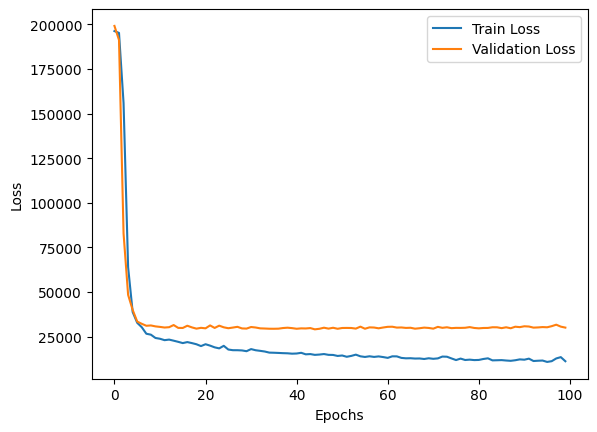

Total parameters: 782337


In [ ]:
model.eval()
y_pred, y_true = [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        output = model(X_batch)
        y_pred.extend(output.view(-1).tolist())
        y_true.extend(y_batch.view(-1).tolist())

mse, rmse, r2 = mean_squared_error(y_true, y_pred), mean_squared_error(y_true, y_pred) ** 0.5, r2_score(y_true, y_pred)

print(f'MSE: {mse}\nRMSE: {rmse}\nR² Score: {r2}')

plt.plot(train_losses, label='Train Loss'); plt.plot(val_losses, label='Validation Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.show()

total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')
torch.save(model, 'model_complete.pth')
